In [1]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph
#!{sys.executable} -m pip install igraph
from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt
#!{sys.executable} -m pip install cdlib


import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

In [2]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [9]:
G = nx.read_weighted_edgelist('../../data/tuscanyJ_backboned.weighted.edgelist',delimiter=',')
len(G.nodes)

15520

In [10]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
     G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    #G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [11]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


average componets size:  2.1875
17
[15485, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] etc...


In [12]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [13]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [14]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15485


In [15]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [16]:
df.to_csv('../data/connenctedJ.csv')
nx.write_weighted_edgelist(G,'../data/connectedJ.weighted.edgelist')

## Data Loading

In [18]:
G = nx.read_weighted_edgelist('../data/connectedJ.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connenctedJ.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    #G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
3,15,1330,Blend,Sesto Fiorentino,True,/Restaurant_Review-g194916-d12955635-Reviews-B...,4.0,198,2.5,Blend,...,43.830860,11.206403,"Italian, Pizza, Mediterranean, Barbecue","Dinner, Lunch","Vegetarian Friendly, Gluten Free Options",8SH_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g194916-d12955635-Reviews-B...,1,NaN
4,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN


In [19]:
def assign(g,communities, attribute, overlap=False):
    
    if ~overlap:
        
        for label, community in enumerate(communities.communities):
            for node in community:
                g.nodes[node][attribute] = label
                
    else: 
        
        for node in g.nodes:
            g.nodes[node][attribute] = list()
            
        for label, community in enumerate(communities.communities):
            g.nodes[node][attribute].append(label)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

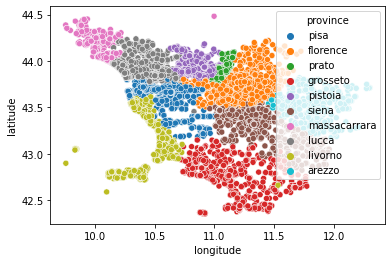

In [20]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

In [21]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}

In [22]:
provinces =  {"communities":[[] for _ in df['province'].unique()]}
for i, c in df['province'].items():
    provinces['communities'][provincemapping[c]].append(i)
   
provinces["algorithm"] = 'provinces'
provinces["params"] =  {"initial_membership": None, "weights": None}
provinces["overlap"] = False
provinces["coverage"]= 1.0
with open('../data/communities/provinces.json','w+') as jf:
    json.dump(provinces, jf)


## Crisp Communities

### K means 
Use longitude and latitude

In [24]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['latitude','longitude']])
print(pd.Series(kmeans.labels_).value_counts())

1    3599
6    2548
2    2045
9    1712
4    1135
3    1115
0    1069
7    1055
5     759
8     448
dtype: int64


In [25]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

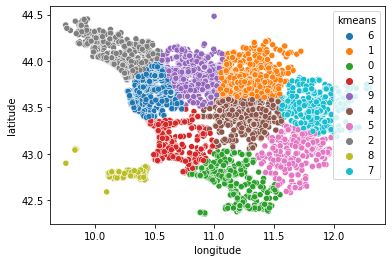

In [26]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [27]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
  
data["algorithm"] = 'kmeans'
data["params"] =  {"initial_membership": None, "weights": None}
data["overlap"] = False
data["coverage"]= 1.0
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [28]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [30]:
louvain = cd.louvain(G, resolution=1,weight='dissimilarity')
print(len(louvain.communities),[len(c) for c in louvain.communities ])


17 [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

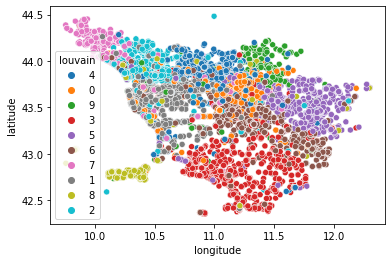

In [31]:
readwrite.write_community_json(louvain,'../data/communities/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### greedy modularity

In [32]:
greedy_modularity = cd.greedy_modularity(G)
readwrite.write_community_json(greedy_modularity,'../data/communities/greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

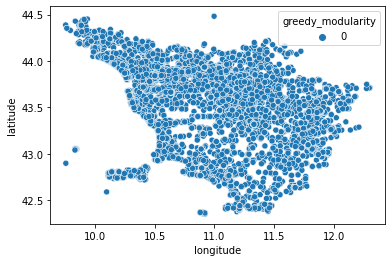

In [33]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

In [34]:
greedy_modularity = cd.greedy_modularity(G,weight='dissimilarity')
readwrite.write_community_json(greedy_modularity,'../data/communities/weighted_greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

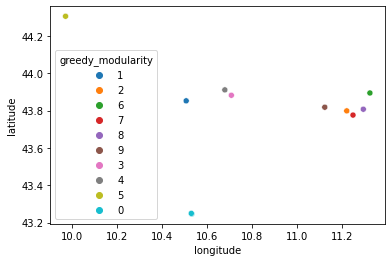

In [35]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

### Leiden

In [36]:
leiden= cd.leiden(G)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

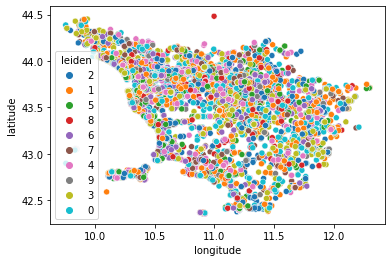

In [37]:
readwrite.write_community_json(leiden,'../data/communities/leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

In [38]:
leiden= cd.leiden(G,weights='dissimilarity')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

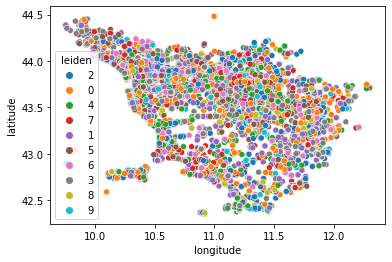

In [39]:
readwrite.write_community_json(leiden,'../data/communities/weighted_leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

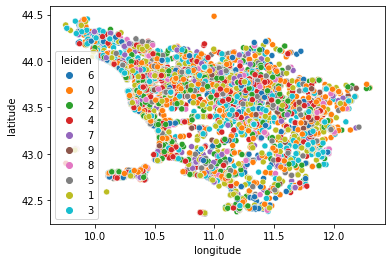

In [40]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes], weights='dissimilarity')
readwrite.write_community_json(leiden_p,'../data/communities/leiden_wp.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

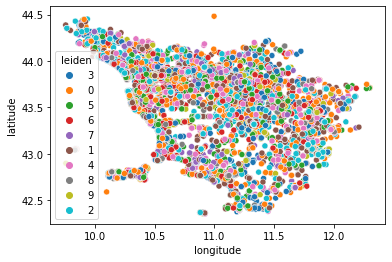

In [41]:
leiden_p= cd.leiden(G, initial_membership = [G.nodes[node]['provint'] for node in G.nodes])
readwrite.write_community_json(leiden_p,'../data/communities/leiden_p.json')
assign(G,leiden_p,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])
sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Label Propagation

In [42]:
label_propagation = cd.label_propagation(G)
readwrite.write_community_json(label_propagation,'../data/communities/label_propagation.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

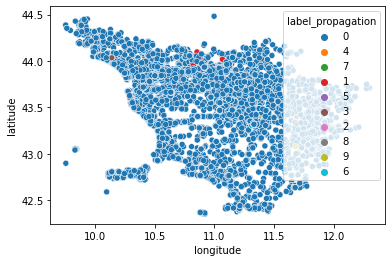

In [43]:

assign(G,label_propagation,'label_propagation')
for node in G.nodes:
    df.loc[node,'label_propagation'] = str(G.nodes[node]['label_propagation'])

sns.scatterplot(data = df[df.label_propagation.astype(int)<10], x='longitude',y='latitude',hue='label_propagation')

### Async Fluid


In [46]:
async_fluid = cd.async_fluid(G,k=10)
readwrite.write_community_json(async_fluid,'../data/communities/async_fluid10.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

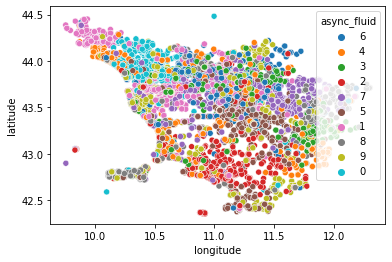

In [47]:
assign(G,async_fluid,'async_fluid')
for node in G.nodes:
    df.loc[node,'async_fluid'] = str(G.nodes[node]['async_fluid'])

sns.scatterplot(data = df[df.async_fluid.astype(int)<10], x='longitude',y='latitude',hue='async_fluid')

### Rb / Rber Pots

In [149]:

provinceMapping= { p:i for i,p in enumerate(df.province.unique())}
for node in G.nodes:
     G.nodes[node]['provint'] = provinceMapping[G.nodes[node]['province']]
                                            

In [48]:
for node in list(G.nodes())[:10]: print(G.nodes[node])

{'province': 'pisa', 'kmeans': '6', 'louvain': 4, 'greedy_modularity': 1, 'leiden': 3, 'provint': 0, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 2, 'leiden': 0, 'provint': 1, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 3, 'leiden': 3, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'pistoia', 'kmeans': '9', 'louvain': 4, 'greedy_modularity': 4, 'leiden': 0, 'provint': 4, 'label_propagation': 0, 'async_fluid': 6}
{'province': 'massacarrara', 'kmeans': '2', 'louvain': 7, 'greedy_modularity': 5, 'leiden': 0, 'provint': 6, 'label_propagation': 0, 'async_fluid': 1}
{'province': 'prato', 'kmeans': '1', 'louvain': 4, 'greedy_modularity': 6, 'leiden': 0, 'provint': 2, 'label_propagation': 0, 'async_fluid': 4}
{'province': 'florence', 'kmeans': '1', 'louvain': 0, 'greedy_modularity': 7, 'leiden': 0, 'provint': 1, 'label_propagation

In [50]:

rb_pots = cd.rb_pots( G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()], resolution_parameter=0.7)


readwrite.write_community_json(rb_pots,'../data/communities/rb_pots.json')
print(len(rb_pots.communities),[len(c) for c in rb_pots.communities])

10 [3576, 3415, 2610, 1928, 1298, 1194, 937, 437, 83, 7]


In [71]:
for c in rb_pots.communities: print(len(c))

3335
2929
2712
2508
1741
1008
415
149
65
53
51
21
6
5
5


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

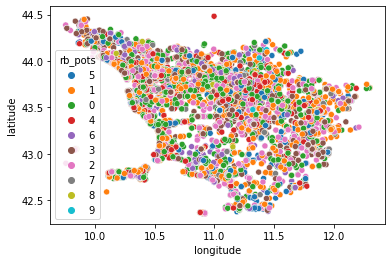

In [51]:
assign(G,rb_pots,'rb_pots')
for node in G.nodes:
    df.loc[node,'rb_pots'] = str(G.nodes[node]['rb_pots'])

sns.scatterplot(data = df[df.rb_pots.astype(int)<20], x='longitude',y='latitude',hue='rb_pots')

In [52]:
for node in G.nodes: G.nodes[node]['size'] = int(df.loc[node,'N_reviews'])

In [54]:
rber_pots = cd.rber_pots(G, initial_membership =[G.nodes[node]['provint'] for node in G.nodes()],node_sizes=[G.nodes[node]['size'] for node in G.nodes()] ,weights='dissimilarity',resolution_parameter=0.8)
readwrite.write_community_json(rber_pots,'../data/communities/rber_pots.json')
print(len(rber_pots.communities))

841


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

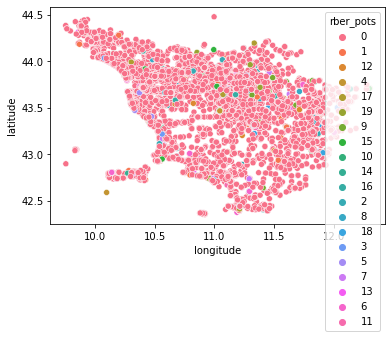

In [55]:
assign(G,rber_pots,'rber_pots')
for node in G.nodes:
    df.loc[node,'rber_pots'] = str(G.nodes[node]['rber_pots'])

sns.scatterplot(data = df[df.rber_pots.astype(int)<20], x='longitude',y='latitude',hue='rber_pots')

## Overlapping Communities

### Angel 

In [56]:
angel = cd.angel(G, min_community_size=10, threshold=0.2)
readwrite.write_community_json(angel,'../data/communities/angel.json')

In [57]:
print(len(angel.communities))
print([len(c) for c in angel.communities ])

6
[8955, 30, 20, 19, 15, 10]


In [30]:
assign(G,angel,'angel',overlap=True)


#sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='angel')

### Demon

In [58]:
demon = cd.demon(G, min_com_size=10,epsilon=0.1)
print(len(demon.communities))
readwrite.write_community_json(demon,'../data/communities/demon.json')

135


In [59]:
print([len(c) for c in demon.communities ])

[2801, 2574, 2089, 1766, 1634, 1513, 1481, 1469, 1440, 1435, 1323, 1186, 1111, 1098, 1012, 994, 949, 934, 933, 904, 820, 819, 815, 788, 781, 767, 747, 745, 735, 719, 711, 710, 697, 693, 689, 684, 684, 680, 664, 635, 631, 630, 619, 619, 614, 607, 598, 595, 592, 591, 589, 587, 585, 583, 579, 577, 572, 568, 566, 560, 548, 545, 541, 538, 536, 530, 515, 509, 496, 494, 491, 490, 472, 470, 463, 461, 459, 454, 453, 444, 430, 428, 425, 415, 415, 413, 403, 380, 380, 379, 374, 365, 359, 356, 340, 333, 331, 330, 315, 308, 307, 305, 302, 300, 291, 288, 276, 269, 265, 261, 259, 250, 242, 209, 207, 174, 166, 166, 165, 163, 158, 87, 64, 50, 46, 34, 31, 24, 23, 22, 19, 16, 14, 11, 11]


## Attribute Comunities
### Ilouvain

In [79]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
maxW = max([ G.edges[edge]['weight'] for edge in G.edges]) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['weight'] =  maxW+1 - G.edges[edge]['weight']
    
for node in list(G.nodes)[:10]: print(node,G.nodes[node])

0 {}
1 {}
2 {}
3 {}
4 {}
5 {}
6 {}
8 {}
9 {}
14 {}


In [80]:
print(len(G), max([node for node in G.nodes]))

15003 15002


In [81]:
df.isnull().sum()

index                   0
position                0
name                    0
city                    2
menu                    0
link                    0
score                 518
N_reviews               0
price                2892
Name                    0
Province                0
City                    0
claimed                 0
covidMeasure            0
travellersChoice        0
latitude                0
longitude               0
cuisines             1337
meals                6281
specialDiets         8389
positionlink            1
province                0
Link                 1752
provinceOK              0
longitud§e          14237
dtype: int64

In [82]:
for node in G.nodes: G.nodes[node]['province'] = None#df.loc[node,'province']

In [23]:
provincemapping = {e:i for i,e in enumerate(df.province.unique())}
for node in G.nodes:
    G.nodes[node]['provint'] = provincemapping[df.loc[node,'province']]
    

In [ ]:
provincemapi

In [83]:
attributes = ['latitude','longitude','N_reviews','covidMeasure','travellersChoice','claimed','menu']

In [84]:
for node in G.nodes:
    for attr in attributes: 
        G.nodes[node][attr] = float(df.loc[node,attr])

In [85]:
for node in list(G.nodes)[:10]: print(node,G.nodes[node])

0 {'province': None, 'latitude': 43.85180773789867, 'longitude': 10.506207, 'N_reviews': 6.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 0.0}
1 {'province': None, 'latitude': 43.798058, 'longitude': 11.219482, 'N_reviews': 229.0, 'covidMeasure': 1.0, 'travellersChoice': 1.0, 'claimed': 1.0, 'menu': 1.0}
2 {'province': None, 'latitude': 43.76428, 'longitude': 11.180183, 'N_reviews': 236.0, 'covidMeasure': 0.0, 'travellersChoice': 1.0, 'claimed': 1.0, 'menu': 0.0}
3 {'province': None, 'latitude': 43.77555, 'longitude': 11.247292, 'N_reviews': 162.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 0.0}
4 {'province': None, 'latitude': 43.806915, 'longitude': 11.293199, 'N_reviews': 754.0, 'covidMeasure': 0.0, 'travellersChoice': 0.0, 'claimed': 1.0, 'menu': 1.0}
5 {'province': None, 'latitude': 43.76676, 'longitude': 11.247868, 'N_reviews': 215.0, 'covidMeasure': 0.0, 'travellersChoice': 1.0, 'claimed': 0.0, 'menu': 0.0}
6 {'province': None

In [86]:
labels = { int(node) : {attr:int(G.nodes[node][attr]) for attr in attributes} for node in G.nodes()}


In [87]:

ilouvain = cd.ilouvain(G,labels,{node:node for node in G.nodes})

MemoryError: Unable to allocate 1.68 GiB for an array with shape (225090009,) and data type float64

In [ ]:

readwrite.write_community_json(ilouvain,'../data/communities/ilouvain.json')

## Evaluation


In [4]:
G = nx.read_weighted_edgelist('../data/connectedJ.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connenctedJ.csv',index_col=0)
#for node in G.nodes:
 #   G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [5]:
nx.is_connected(G)

True

In [60]:
import os 
data = dict()


for f in os.listdir('../data/communities'):
    if f[-5:] != '.json': continue
   
    name = f[:-5]
    
    communities = readwrite.read_community_json(f'../data/communities/{f}')
    data[name] = communities
    print(name,' -> ',len(communities.communities),' -> ', [len(c) for c in communities.communities[:20]])

provinces  ->  10  ->  [3645, 1949, 1796, 1647, 1571, 1460, 1124, 967, 791, 535]
kmeans  ->  10  ->  [3599, 2548, 2045, 1712, 1135, 1115, 1069, 1055, 759, 448]
louvain  ->  17  ->  [2463, 2409, 1894, 1847, 1839, 1336, 1225, 877, 537, 455, 389, 165, 20, 11, 11, 6, 1]
greedy_modularity  ->  1  ->  [15485]
weighted_greedy_modularity  ->  15484  ->  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leiden  ->  13  ->  [2387, 2348, 1839, 1824, 1566, 1424, 1353, 936, 580, 536, 499, 188, 5]
weighted_leiden  ->  18  ->  [2268, 2119, 1821, 1757, 1677, 1420, 1099, 965, 644, 606, 426, 332, 280, 39, 21, 6, 4, 1]
leiden_wp  ->  17  ->  [2970, 2323, 1969, 1874, 1705, 1175, 1075, 904, 554, 464, 384, 42, 13, 11, 9, 8, 5]
leiden_p  ->  15  ->  [2562, 2239, 1860, 1836, 1786, 1718, 1355, 916, 599, 526, 39, 17, 13, 12, 7]
label_propagation  ->  118  ->  [15066, 83, 16, 14, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
async_fluid10  ->  10  ->  [1767, 1617, 1606, 1586, 1576, 1558, 1472, 1470,

### Collect Fitness

In [61]:
all_evalution_functions = [evaluation.avg_distance, evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio, evaluation.purity]  

In [62]:
evaluation_functions = [ evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio]  

In [63]:
scores = {name:{} for name in data.keys() }
for evaluation_function in evaluation_functions:
    f_name = str(evaluation_function).split(' ')[1].upper()
    print(f_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            ev = evaluation_function(G,comm)
            print(ev)
            scores[name][f_name] = ev.score
            
        except Exception as e: 
            print(e) 
            scores[name][f_name] = np.nan
            
    print('\n\n')

AVG_EMBEDDEDNESS
provinces -> FitnessResult(min=0.5112354061315804, max=0.7095952513689398, score=0.6227473310876486, std=0.059518068180675315)
kmeans -> FitnessResult(min=0.49214113516572594, max=0.6813194213764558, score=0.5981328709253376, std=0.06425107057646927)
louvain -> FitnessResult(min=0.0, max=0.9583333333333334, score=0.6337860854951646, std=0.18089564927113497)
greedy_modularity -> FitnessResult(min=1.0, max=1.0, score=1.0, std=0.0)
weighted_greedy_modularity -> FitnessResult(min=0.0, max=0.6666666666666666, score=4.30551967622492e-05, std=0.005357388427041474)
leiden -> FitnessResult(min=0.0, max=0.2118871205165494, score=0.1090097158224337, std=0.06407434443079273)
weighted_leiden -> FitnessResult(min=0.0, max=0.2086185386005571, score=0.08130280561020956, std=0.06470606351310582)
leiden_wp -> FitnessResult(min=0.0, max=0.2169184308465324, score=0.0861054327222222, std=0.07439004843107432)
leiden_p -> FitnessResult(min=0.0, max=0.22063221147336753, score=0.10037199497018

weighted_leiden -> FitnessResult(min=6.45827951433738e-05, max=0.0013496150360063348, score=0.0011045881858487107, std=0.00033072506612036545)
leiden_wp -> FitnessResult(min=0.0005419218837005807, max=0.0013502896890079563, score=0.001131189986736437, std=0.00023229262294620893)
leiden_p -> FitnessResult(min=0.0006662158937236497, max=0.0013496150360063348, score=0.0011307614153436127, std=0.0002008358338651078)
label_propagation -> FitnessResult(min=2.1530379365284418e-05, max=0.0005374047807904779, score=6.585973659441199e-05, std=6.074825005679522e-05)
async_fluid10 -> FitnessResult(min=0.0005496594392348627, max=0.0007156569370523807, score=0.0006219862887069826, std=4.825222873092968e-05)
async_fluid7 -> FitnessResult(min=0.0004724020096952786, max=0.0006031217150503531, score=0.0005470821940783966, std=4.459510471794949e-05)
rb_pots -> FitnessResult(min=0.000572240784154468, max=0.0013411607077619475, score=0.001148069398884761, std=0.00022008100620285706)
rber_pots -> FitnessRes

kmeans -> FitnessResult(min=0.0008217880916522887, max=0.00576761744966443, score=0.0025005854925936838, std=0.0014116592976635158)
louvain -> FitnessResult(min=0, max=0.1, score=0.01597623756242483, std=0.025771273402678894)
greedy_modularity -> FitnessResult(min=0.000317598459255117, max=0.000317598459255117, score=0.000317598459255117, std=0.0)
weighted_greedy_modularity -> FitnessResult(min=0, max=0.25, score=1.614569878584345e-05, std=0.0020090206601405514)
leiden -> FitnessResult(min=0.0, max=0.000798139768728004, score=0.0004221081965553128, std=0.00017984935366309143)
weighted_leiden -> FitnessResult(min=0.0, max=0.004723346828609987, score=0.0006443883175654752, std=0.001025931343633431)
leiden_wp -> FitnessResult(min=0.0, max=0.004545454545454545, score=0.0009946646099793506, std=0.0013989495088923528)
leiden_p -> FitnessResult(min=0.0, max=0.011904761904761904, score=0.0017520290694470603, std=0.002988816136085413)
label_propagation -> FitnessResult(min=0.0003307143446586981

async_fluid7 -> FitnessResult(min=0.19826756496631376, max=0.36911686938127974, score=0.268610312604547, std=0.06303961145229793)
rb_pots -> FitnessResult(min=0.904045643153527, max=1.0, score=0.9543038344877584, std=0.034113042990446506)
rber_pots -> FitnessResult(min=0.0365103127079175, max=1.0, score=0.9967985498627069, std=0.03920188611812994)
angel -> FitnessResult(min=0.16069235064209939, max=1.0, score=0.8601153917736832, std=0.31279149299997056)
demon -> FitnessResult(min=0.21428571428571427, max=0.9166666666666666, score=0.679561672438887, std=0.09893773742385678)



SCALED_DENSITY
provinces -> FitnessResult(min=2.5393132345260763, max=18.209842374901168, score=8.174116259913797, std=4.569670135200026)
kmeans -> FitnessResult(min=2.5875065438909193, max=18.160092662891294, score=7.873418210083446, std=4.444792650991967)
louvain -> FitnessResult(min=0.0, max=314.8629884242389, score=50.30325902680659, std=81.14420159065581)
greedy_modularity -> FitnessResult(min=1.0, max=1.0, s

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:812: RuntimeWarning: divide by zero encountered in log
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))
/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:812: RuntimeWarning: invalid value encountered in double_scalars
  q += binom_c * (pc * np.log(pc / p) + (1 - pc) * np.log((1 - pc) / (1 - p)))


FitnessResult(min=None, max=None, score=nan, std=None)
leiden -> FitnessResult(min=None, max=None, score=nan, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=nan, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=nan, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=nan, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=452740.7224622224, std=None)
async_fluid7 -> FitnessResult(min=None, max=None, score=487707.9753978818, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=nan, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=nan, std=None)
angel -> FitnessResult(min=None, max=None, score=nan, std=None)
demon -> FitnessResult(min=None, max=None, score=3215768.1024604365, std=None)



SIZE
provinces -> FitnessResult(min=535, max=3645, score=1548.5, std=821.8479482240009)
kmeans -> FitnessResult(min=448, max=3599, score=1548.5,

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:769: RuntimeWarning: invalid value encountered in log2
  sp = m * (q * np.log(q / qa) + (1 - q) * np.log2((1 - q) / (1 - qa)))


FitnessResult(min=None, max=None, score=nan, std=None)



TRIANGLE_PARTICIPATION_RATIO
provinces -> FitnessResult(min=0.6484517304189436, max=0.8647281921618205, score=0.7520910107278171, std=0.08039523176354124)
kmeans -> FitnessResult(min=0.6334801762114537, max=0.8549107142857143, score=0.7548930408689579, std=0.07920346870411439)
louvain -> FitnessResult(min=0.0, max=0.8562874251497006, score=0.5714556671360763, std=0.3303819181555847)
greedy_modularity -> FitnessResult(min=0.8012269938650307, max=0.8012269938650307, score=0.8012269938650307, std=0.0)
weighted_greedy_modularity -> FitnessResult(min=0.0, max=0.0, score=0.0, std=0.0)
leiden -> FitnessResult(min=0.0, max=0.3969298245614035, score=0.19934852237136347, std=0.1363723786296493)
weighted_leiden -> FitnessResult(min=0.0, max=0.4040978941377348, score=0.15430209421849017, std=0.13890488310822688)
leiden_wp -> FitnessResult(min=0.0, max=0.41728922091782283, score=0.16561855958141566, std=0.15361101190468013)
leiden_p -> Fitne

In [64]:
f_df = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(evaluation_function).split(' ')[1].upper() for evaluation_function in evaluation_functions])

f_df

,provinces,kmeans,louvain,greedy_modularity,weighted_greedy_modularity,leiden,weighted_leiden,leiden_wp,leiden_p,label_propagation,async_fluid10,async_fluid7,rb_pots,rber_pots,angel,demon
AVG_EMBEDDEDNESS,0.622747,0.598133,0.633786,1.000000,0.000043,0.109010,0.081303,0.086105,0.100372,0.640853,0.565035,0.633703,0.139816,0.003951,0.109875,4.039551e-01
AVERAGE_INTERNAL_DEGREE,12.457666,11.545680,9.221981,19.670778,0.000065,2.051350,1.515453,1.632797,1.856243,1.655247,10.896709,12.397301,2.674002,0.039712,2.424393,1.220136e+01
AVG_TRANSITIVITY,0.149638,0.161472,0.166680,0.108478,0.000000,0.073920,0.062960,0.062969,0.074011,0.038773,0.194520,0.171494,0.089622,0.000971,0.096337,4.917599e-01
CONDUCTANCE,0.388756,0.425070,0.398693,0.000000,0.999968,0.896750,0.923903,0.917191,0.905780,0.406955,0.447623,0.372631,0.865667,0.997417,0.886347,6.077663e-01
CUT_RATIO,0.000551,0.000599,0.000378,0.000000,0.001270,0.001162,0.001105,0.001131,0.001131,0.000066,0.000622,0.000547,0.001148,0.000643,0.001457,1.261656e-03
EDGES_INSIDE,9481.100000,9173.700000,5837.882353,152301.000000,0.000065,1659.076923,1126.277778,1363.764706,1536.200000,1281.669492,8531.400000,13742.285714,3019.800000,138.399524,9585.333333,3.858889e+03
EXPANSION,7.682342,8.378986,5.398592,0.000000,19.671855,16.542187,16.050355,16.403145,16.249870,0.998540,8.669865,7.262762,15.892150,9.948077,20.720728,1.879550e+01
FRACTION_OVER_MEDIAN_DEGREE,0.480592,0.483667,0.413376,0.497514,0.000000,0.363364,0.302244,0.314756,0.324487,0.165868,0.475822,0.477071,0.353554,0.011579,0.236016,4.708639e-01
HUB_DOMINANCE,0.039398,0.038286,NaN,0.004521,NaN,0.012713,NaN,0.024320,0.035453,0.954364,0.031918,0.024917,0.015648,NaN,0.057417,1.487641e-01
INTERNAL_EDGE_DENSITY,0.002596,0.002501,0.015976,0.000318,0.000016,0.000422,0.000644,0.000995,0.001752,0.202560,0.001749,0.001408,0.000543,0.000618,0.004450,1.314525e-02


In [65]:
f_df.to_csv('../data/fitnessMeasuresJ.csv')

### Collect Modularities

In [66]:
all_modularities = [evaluation.erdos_renyi_modularity, evaluation.link_modularity , evaluation.modularity_density , evaluation.newman_girvan_modularity , evaluation.z_modularity]

In [67]:
scores = {name:{} for name in data.keys() }
for modularity in all_modularities:
    m_name = str(modularity).split(' ')[1].upper()
    print(m_name)
    for name, comm in data.items():
        print(name,end= ' -> ')
        try: 
            mod=modularity(G,comm)
            print(mod)
            scores[name][m_name] = mod.score
            
        except Exception as e:
            print(e) 
            scores[name][m_name] = np.nan
            
    print('\n\n')

ERDOS_RENYI_MODULARITY
provinces -> FitnessResult(min=None, max=None, score=0.49441183018946655, std=None)
kmeans -> FitnessResult(min=None, max=None, score=0.4684340894950798, std=None)
louvain -> FitnessResult(min=None, max=None, score=0.5391727584801811, std=None)
greedy_modularity -> FitnessResult(min=None, max=None, score=0.0, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=6.557603733153292e-06, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.033180319883859895, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=0.03241716332354104, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.03326505512387747, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.03516254057454739, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.04636750618148482, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=0.4597805835387216, std=None)
async_fluid7 -> FitnessResult(min=N

/home/ec2-user/.local/lib/python3.7/site-packages/cdlib/evaluation/fitness.py:722: RuntimeWarning: invalid value encountered in double_scalars
  res = (mmc - dc2m) / np.sqrt(dc2m * (1 - dc2m))


FitnessResult(min=None, max=None, score=nan, std=None)
weighted_greedy_modularity -> FitnessResult(min=None, max=None, score=-0.008974234350092066, std=None)
leiden -> FitnessResult(min=None, max=None, score=0.10231087026037743, std=None)
weighted_leiden -> FitnessResult(min=None, max=None, score=0.10024744167435261, std=None)
leiden_wp -> FitnessResult(min=None, max=None, score=0.10361113916135085, std=None)
leiden_p -> FitnessResult(min=None, max=None, score=0.10523579639433721, std=None)
label_propagation -> FitnessResult(min=None, max=None, score=0.10097260270887885, std=None)
async_fluid10 -> FitnessResult(min=None, max=None, score=1.5073293997135957, std=None)
async_fluid7 -> FitnessResult(min=None, max=None, score=1.3819996326290098, std=None)
rb_pots -> FitnessResult(min=None, max=None, score=0.0972013697346664, std=None)
rber_pots -> FitnessResult(min=None, max=None, score=0.024626253351561777, std=None)
angel -> FitnessResult(min=None, max=None, score=0.009387866369193315, st

In [68]:
m_df = pd.DataFrame(scores)#, index = [name for name in data.keys()],columns = [str(modularity).split(' ')[1].upper() for modularity in all_modularities])
m_df

,provinces,kmeans,louvain,greedy_modularity,weighted_greedy_modularity,leiden,weighted_leiden,leiden_wp,leiden_p,label_propagation,async_fluid10,async_fluid7,rb_pots,rber_pots,angel,demon
ERDOS_RENYI_MODULARITY,0.494412,0.468434,0.539173,0.000000,6.557604e-06,0.033180,0.032417,0.033265,0.035163,0.046368,0.459781,0.487919,0.034996,0.161029,0.043196,3.115386
LINK_MODULARITY,0.090054,0.087134,0.094264,NaN,9.498229e-07,0.020486,0.019256,0.022021,0.021887,NaN,0.081033,0.091369,0.028683,NaN,NaN,0.117237
MODULARITY_DENSITY,47.753240,31.666932,64.997619,19.670778,-3.045980e+05,-188.380877,-261.628239,-251.095928,-215.904405,77.491360,22.268439,35.941770,-132.181480,-8332.935462,-109.778013,-890.209844
NEWMAN_GIRVAN_MODULARITY,0.527735,0.502586,0.634118,0.000000,8.209509e-05,0.046977,0.039551,0.045896,0.046157,0.078011,0.557399,0.580483,0.045218,0.011125,-0.326231,0.230205
Z_MODULARITY,1.525067,1.405646,1.714450,NaN,-8.974234e-03,0.102311,0.100247,0.103611,0.105236,0.100973,1.507329,1.382000,0.097201,0.024626,0.009388,6.529580


In [69]:
m_df.to_csv('../data/modularityMeasures.csv')

In [70]:
m_df.transpose()

,ERDOS_RENYI_MODULARITY,LINK_MODULARITY,MODULARITY_DENSITY,NEWMAN_GIRVAN_MODULARITY,Z_MODULARITY
provinces,0.494412,9.005366e-02,47.753240,0.527735,1.525067
kmeans,0.468434,8.713390e-02,31.666932,0.502586,1.405646
louvain,0.539173,9.426422e-02,64.997619,0.634118,1.714450
greedy_modularity,0.000000,NaN,19.670778,0.000000,NaN
weighted_greedy_modularity,0.000007,9.498229e-07,-304598.000000,0.000082,-0.008974
leiden,0.033180,2.048578e-02,-188.380877,0.046977,0.102311
weighted_leiden,0.032417,1.925576e-02,-261.628239,0.039551,0.100247
leiden_wp,0.033265,2.202069e-02,-251.095928,0.045896,0.103611
leiden_p,0.035163,2.188677e-02,-215.904405,0.046157,0.105236
label_propagation,0.046368,NaN,77.491360,0.078011,0.100973


In [71]:
m_df.columns

Index(['provinces', 'kmeans', 'louvain', 'greedy_modularity',
       'weighted_greedy_modularity', 'leiden', 'weighted_leiden', 'leiden_wp',
       'leiden_p', 'label_propagation', 'async_fluid10', 'async_fluid7',
       'rb_pots', 'rber_pots', 'angel', 'demon'],
      dtype='object')

In [72]:
 for name, comm in data.items():
        if comm.node_coverage==1:
            print(name,' -> ', evaluation.adjusted_mutual_information(comm, data['provinces']).score)

provinces  ->  1.0
kmeans  ->  0.7097607937446297
louvain  ->  0.5240196777074466
greedy_modularity  ->  -7.68579945638074e-16
weighted_greedy_modularity  ->  2.0894125279142746e-05
leiden  ->  0.01840383346381873
weighted_leiden  ->  0.01799502025917599
leiden_wp  ->  0.020857991126838806
leiden_p  ->  0.020295636961773836
label_propagation  ->  0.014743386119125805
async_fluid10  ->  0.27597804969986567
async_fluid7  ->  0.31604225230145705
rb_pots  ->  0.020851158732683252
rber_pots  ->  0.005266759444165657


In [73]:

pd.plotting.scatter_matrix(m_df[['angel','async_fluid_7', 'demon',
       'kmeans', 'label_propagation', 'leiden_p', 'louvain',
       'rb_pots', 'rber_pots', 'greedy_modularity']])
plt.show()

KeyError: "['async_fluid_7'] not in index"

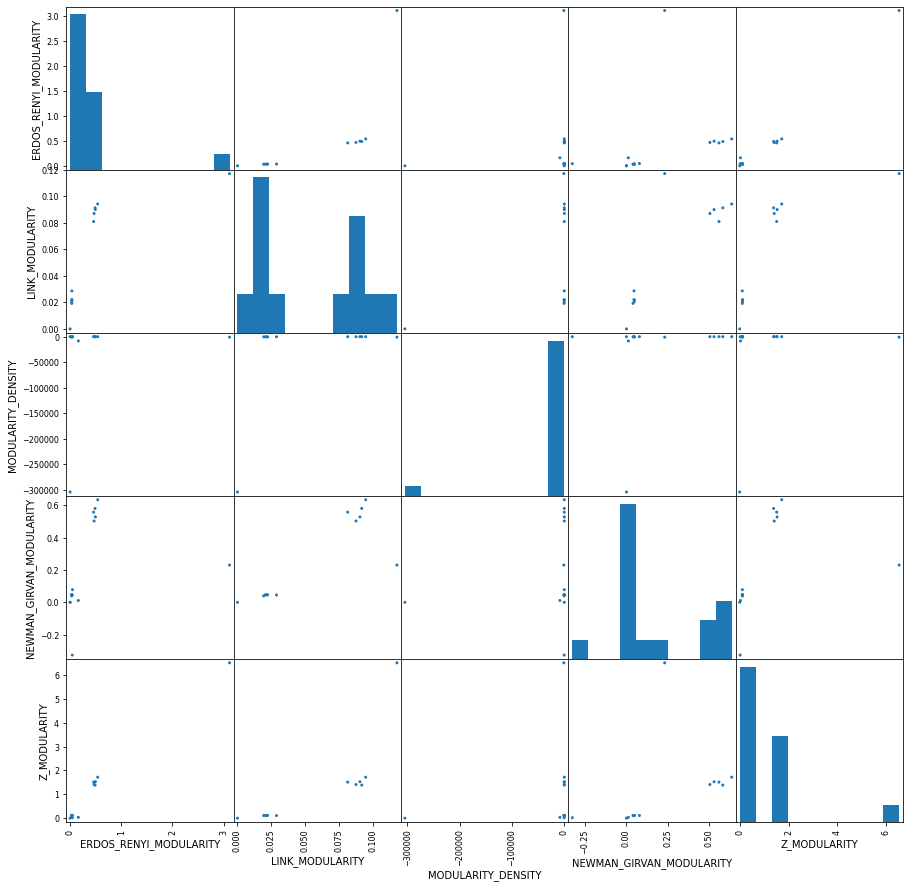

In [74]:

pd.plotting.scatter_matrix(m_df.transpose(),figsize=(15,15),alpha = 1)
plt.show()